<a href="https://colab.research.google.com/github/nedokormysh/GB_ML_business/blob/lesson2/ML_business_hw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pymorphy2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 61.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
!pip install pyLDAvis -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


In [4]:
import pandas as pd

In [5]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt 
!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv

--2023-01-30 10:20:28--  https://docs.google.com/uc?export=download&confirm=t&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR
Resolving docs.google.com (docs.google.com)... 142.251.16.113, 142.251.16.100, 142.251.16.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.16.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/46rtvu03mp281ilvlb6icd67fqj5ha5n/1675074000000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download&uuid=3f5c061d-3362-49d8-8995-63c043d8e49d [following]
--2023-01-30 10:20:28--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/46rtvu03mp281ilvlb6icd67fqj5ha5n/1675074000000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download&uuid=3f5c061d-3362-49d8-8995-63c043d8e49d
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 142.251.16.132, 

Наши новости

In [6]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [7]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


# 1. 

Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

# 2. 

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

## Для среднего (повтор занятия)

### Получаем векторные представления новостей

In [8]:
from gensim.corpora.dictionary import Dictionary
#предобработка текстов
import re
import numpy as np

from razdel import tokenize # https://github.com/natasha/razdel
import pymorphy2

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [11]:
!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt -q

In [12]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [13]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [14]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста.
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

  0%|          | 0/27000 [00:00<?, ?it/s]<ipython-input-13-07c10c78c7a6>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
100%|██████████| 27000/27000 [00:43<00:00, 620.28it/s] 

CPU times: user 34.4 s, sys: 1.99 s, total: 36.4 s
Wall time: 43.6 s


In [15]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 32s, sys: 644 ms, total: 3min 32s
Wall time: 3min 34s


А теперь в 3 строчки обучим нашу модель

In [16]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [17]:
N_topic = 20

In [18]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=10)

CPU times: user 5min 12s, sys: 2min 35s, total: 7min 47s
Wall time: 5min 14s


In [19]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [20]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.026725758), (3, 0.16618112), (8, 0.24597123), (19, 0.5411219)]

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [21]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: млн рак фестиваль тыс задержать фильм квартира
topic_1: доллар аэропорт египет офицер форум евро сенатор
topic_2: станция товар продукция тело способ космонавт страдать
topic_3: москва московский мероприятие область школа церковь праздник
topic_4: ребёнок погибнуть сотрудник уголовный пострадать орган убийство
topic_5: женщина смерть жизнь мужчина врач заболевание животное
topic_6: учёный исследование научный журнал риск опубликовать университет
topic_7: млрд россия рубль всё уровень эксперт гражданин
topic_8: система всё ракета новый космический земля очень
topic_9: самолёт корабль полёт луна российский экипаж море
topic_10: россия российский военный путин рф владимир вопрос
topic_11: турист советский ссср русский история площадь территория
topic_12: украина украинский фонд снижение киев восток порошенко
topic_13: день исследователь обнаружить изз произойти место выяснить
topic_14: армия сила сирия войско война государство удар
topic_15: поставка взрыв турция решение территор

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [22]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [23]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.        , 0.        , 0.0391989 , 0.        ,
       0.        , 0.        , 0.        , 0.0198014 , 0.        ,
       0.18497783, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01019434, 0.64108533, 0.        , 0.09860185])

In [24]:
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.000000,0.000000,0.039195,0.0,0.0,0.0,0.0,0.019813,...,0.184892,0.0,0.000000,0.000000,0.000000,0.000000,0.010194,0.641161,0.000000,0.098604
1,4896,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.360719,0.000000,0.000000,0.000000,0.617330
2,4897,0.0,0.000000,0.026726,0.166182,0.0,0.0,0.0,0.0,0.245954,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.541138
3,4898,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.264305,...,0.021725,0.0,0.029853,0.175327,0.023342,0.000000,0.000000,0.000000,0.093371,0.367644
4,4899,0.0,0.029982,0.000000,0.000000,0.0,0.0,0.0,0.0,0.037209,...,0.322520,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.224126,0.161966,0.205277


### Следующий шаг - векторные представления пользователей

In [25]:
users.head(5)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [26]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [27]:
doc_dict[293672]

array([0.15319853, 0.        , 0.        , 0.33297583, 0.        ,
       0.        , 0.        , 0.14984073, 0.        , 0.        ,
       0.04999057, 0.04549048, 0.        , 0.        , 0.        ,
       0.12239845, 0.        , 0.13310541, 0.        , 0.        ])

In [28]:
def get_user_embedding(user_articles_list, doc_dict, func):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = func(user_vector, axis=0)
    return user_vector

In [29]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict, np.mean)

array([0.03709576, 0.        , 0.        , 0.00616164, 0.14478505,
       0.03032746, 0.00468326, 0.10210264, 0.08587079, 0.04459966,
       0.27765744, 0.00759219, 0.00526712, 0.00979398, 0.0449551 ,
       0.00420435, 0.        , 0.03223779, 0.1470465 , 0.00370128])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [30]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, np.mean))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.039679,0.020306,0.018729,0.151077,0.116729,0.065025,0.016814,0.032323,0.011755,...,0.083292,0.081538,0.070292,0.025059,0.041542,0.072550,0.004435,0.045283,0.016999,0.072566
1,u108690,0.043320,0.018217,0.002522,0.012161,0.142464,0.030534,0.011199,0.140708,0.044292,...,0.129405,0.015930,0.158626,0.035844,0.033155,0.015746,0.004617,0.023184,0.111484,0.011678
2,u108339,0.018328,0.016017,0.002081,0.038970,0.206933,0.005555,0.010583,0.043924,0.015074,...,0.125808,0.040698,0.024750,0.131417,0.159980,0.020468,0.003998,0.069082,0.032473,0.003765


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [31]:
!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv

--2023-01-30 10:30:47--  https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK
Resolving drive.google.com (drive.google.com)... 142.250.31.102, 142.250.31.139, 142.250.31.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.31.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/oh5qgfgvr942gaitcd5093m6flhfd5hn/1675074600000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download&uuid=e93aadda-4265-4d0f-a8b1-53384c38fc5c [following]
--2023-01-30 10:30:48--  https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/oh5qgfgvr942gaitcd5093m6flhfd5hn/1675074600000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download&uuid=e93aadda-4265-4d0f-a8b1-53384c38fc5c
Resolving doc-0k-c0-docs.googleusercontent.com (doc-0k-c0-docs.googleusercontent.com)... 142.251.16.132, 2607:

In [32]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [33]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.039679,0.020306,0.018729,0.151077,0.116729,0.065025,0.016814,0.032323,0.011755,...,0.081538,0.070292,0.025059,0.041542,0.072550,0.004435,0.045283,0.016999,0.072566,0
1,u108690,0.043320,0.018217,0.002522,0.012161,0.142464,0.030534,0.011199,0.140708,0.044292,...,0.015930,0.158626,0.035844,0.033155,0.015746,0.004617,0.023184,0.111484,0.011678,1
2,u108339,0.018328,0.016017,0.002081,0.038970,0.206933,0.005555,0.010583,0.043924,0.015074,...,0.040698,0.024750,0.131417,0.159980,0.020468,0.003998,0.069082,0.032473,0.003765,1


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [35]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=42, test_size=0.25)

In [36]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [37]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.00537365, 0.04540673, 0.0052513 , 0.04012326, 0.1286483 ,
       0.04732804, 0.01579466, 0.15982396, 0.66904606, 0.01970462])

In [38]:
# создадим датафрейм для сбора всех результатов в таблицу
df_results = pd.DataFrame(columns=['model', 'threshold', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
df_results

,model,threshold,F-Score,Precision,Recall,ROC AUC


### Рассчитаем Precision, Recall, F_score

In [39]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [40]:
# plt.plot( preds[:100], label = 'predict')
# plt.plot(y_test.values[:100], label = 'true')
# plt.title('ответ модели')
# plt.xlabel(' № примера')
# plt.ylabel(' выход')
# plt.legend()
# plt.grid('On')
# plt.show()

In [41]:
def draw_res(y_test, preds):
  plt.plot(preds[:100], label = 'predict')
  plt.plot(y_test.values[:100], label = 'true')
  plt.title('ответ модели')
  plt.xlabel(' № примера')
  plt.ylabel(' выход')
  plt.legend()
  plt.grid('On')
  plt.show()

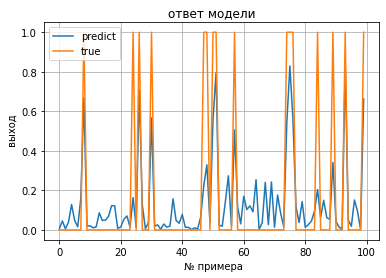

In [42]:
draw_res(y_test, preds)

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test.values, preds)
fscore = (2 * precision * recall) / (precision + recall)

In [44]:
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.29190975633551586, F-Score=0.785, Precision=0.764, Recall=0.806


In [45]:
def draw_res_2(recall, precision):
  n = -1
  plt.plot(recall[:n],precision[:n] )
  plt.title(' точность/полнота')
  plt.xlabel(' полнота')
  plt.ylabel(' точность')
  plt.grid('On')
  plt.show()

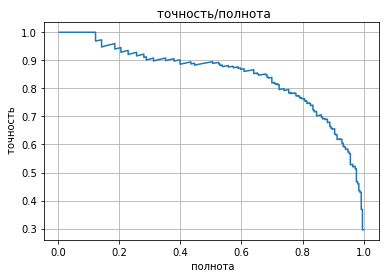

In [46]:
draw_res_2(recall, precision)

In [47]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9750651031355843

In [48]:
df_results.loc[len(df_results.index)] = ['mean', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc]
df_results

,model,threshold,F-Score,Precision,Recall,ROC AUC
0,mean,0.29191,0.784615,0.764045,0.806324,0.975065


# 2.

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [49]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, np.median))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.005387,0.000000,0.012643,0.105486,0.042810,0.047992,0.0,0.000000,0.000000,...,0.071928,0.056107,0.000000,0.000000,0.024795,0.029128,0.0,0.034488,0.000000,0.013403
1,u108690,0.034320,0.005966,0.000000,0.000000,0.098090,0.020055,0.0,0.119442,0.034411,...,0.109090,0.000000,0.107280,0.025172,0.036168,0.000000,0.0,0.005680,0.023266,0.000000
2,u108339,0.011855,0.018317,0.000000,0.042872,0.193327,0.000000,0.0,0.045292,0.012606,...,0.140883,0.048826,0.027492,0.022928,0.038483,0.020785,0.0,0.030776,0.005312,0.000000


In [50]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.005387,0.000000,0.012643,0.105486,0.042810,0.047992,0.0,0.000000,0.000000,...,0.056107,0.000000,0.000000,0.024795,0.029128,0.0,0.034488,0.000000,0.013403,0
1,u108690,0.034320,0.005966,0.000000,0.000000,0.098090,0.020055,0.0,0.119442,0.034411,...,0.000000,0.107280,0.025172,0.036168,0.000000,0.0,0.005680,0.023266,0.000000,1
2,u108339,0.011855,0.018317,0.000000,0.042872,0.193327,0.000000,0.0,0.045292,0.012606,...,0.048826,0.027492,0.022928,0.038483,0.020785,0.0,0.030776,0.005312,0.000000,1


In [51]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=42, test_size=0.25)

In [52]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [53]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0051581 , 0.09250017, 0.0037732 , 0.06227265, 0.23473104,
       0.02981791, 0.00785327, 0.16575992, 0.82821097, 0.04159777])

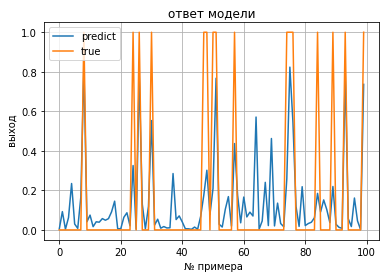

In [54]:
draw_res(y_test, preds)

In [55]:
precision, recall, thresholds = precision_recall_curve(y_test.values, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.2719836013585423, F-Score=0.756, Precision=0.725, Recall=0.791


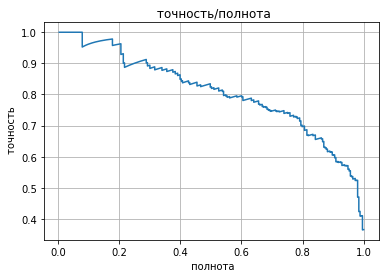

In [56]:
draw_res_2(recall, precision)

In [57]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9697686151980469

In [58]:
df_results.loc[len(df_results.index)] = ['median', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc]
df_results

,model,threshold,F-Score,Precision,Recall,ROC AUC
0,mean,0.291910,0.784615,0.764045,0.806324,0.975065
1,median,0.271984,0.756144,0.724638,0.790514,0.969769


# 3.

Повторить п.2, но используя уже не медиану, а max

In [59]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, np.max))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.153199,0.103539,0.050180,0.362514,0.348302,0.165857,0.074446,0.149841,0.040116,...,0.213179,0.288856,0.373045,0.150354,0.135095,0.254645,0.026610,0.133105,0.101995,0.289086
1,u108690,0.131502,0.052526,0.015134,0.037097,0.469811,0.099940,0.040521,0.346752,0.144400,...,0.252852,0.065307,0.319917,0.115541,0.075295,0.083661,0.016518,0.094087,0.469846,0.046550
2,u108339,0.054917,0.027655,0.012484,0.085352,0.378536,0.033327,0.045598,0.102192,0.035716,...,0.223289,0.076325,0.055425,0.407393,0.522280,0.046830,0.023988,0.265524,0.172841,0.022589


In [60]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.153199,0.103539,0.050180,0.362514,0.348302,0.165857,0.074446,0.149841,0.040116,...,0.288856,0.373045,0.150354,0.135095,0.254645,0.026610,0.133105,0.101995,0.289086,0
1,u108690,0.131502,0.052526,0.015134,0.037097,0.469811,0.099940,0.040521,0.346752,0.144400,...,0.065307,0.319917,0.115541,0.075295,0.083661,0.016518,0.094087,0.469846,0.046550,1
2,u108339,0.054917,0.027655,0.012484,0.085352,0.378536,0.033327,0.045598,0.102192,0.035716,...,0.076325,0.055425,0.407393,0.522280,0.046830,0.023988,0.265524,0.172841,0.022589,1


In [61]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=42, test_size=0.25)

In [62]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [63]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([3.21512720e-04, 4.58574867e-03, 6.32002618e-03, 1.82973364e-03,
       6.37579503e-02, 8.02282556e-02, 1.34287624e-02, 6.17453906e-02,
       6.78374735e-01, 8.88730657e-03])

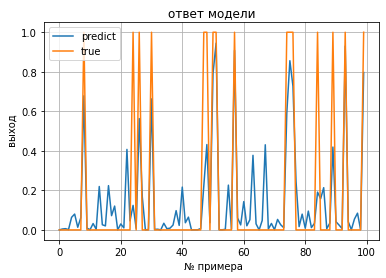

In [64]:
draw_res(y_test, preds)

In [65]:
precision, recall, thresholds = precision_recall_curve(y_test.values, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3656641712615174, F-Score=0.747, Precision=0.786, Recall=0.711


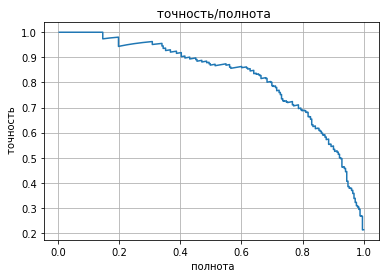

In [66]:
draw_res_2(recall, precision)

In [67]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9608408316006434

In [68]:
df_results.loc[len(df_results.index)] = ['max', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc]
df_results

,model,threshold,F-Score,Precision,Recall,ROC AUC
0,mean,0.291910,0.784615,0.764045,0.806324,0.975065
1,median,0.271984,0.756144,0.724638,0.790514,0.969769
2,max,0.365664,0.746888,0.786026,0.711462,0.960841


# 4.

(опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

Будем интерпретировать индексы статей пользователей как слова. Попробуем получить взвешенную оценку насколько статья является распространённой

In [70]:
users['articles'].iloc[0]

'[293672, 293328, 293001, 293622, 293126, 1852]'

В tf_idf необходимо передавать строку, поэтому переведём в строки.

In [71]:
users['articles_'] = users['articles'].apply(lambda x: x.replace('[','').replace(']', '').replace(',', ''))

# users['articles_'].iloc[0]
users['articles_'].head(3)

0    293672 293328 293001 293622 293126 1852
1            3405 1739 2972 1158 1599 322665
2            1845 2009 2356 1424 2939 323389
Name: articles_, dtype: object

Воспользуемся tf_idf

In [72]:
tfidf = TfidfVectorizer()
tfidf.fit(users['articles_'])

TfidfVectorizer()

In [73]:
idf = pd.DataFrame({'article_id': tfidf.get_feature_names_out(),
                    'idf': tfidf.idf_})

idf

,article_id,idf
0,10,8.888710
1,100,7.907880
2,1000,8.041412
3,1001,8.888710
4,1002,8.888710
...,...,...
14776,995,8.377884
14777,996,8.195562
14778,997,8.601027
14779,998,9.294175


In [74]:
# def get_user_embedding(user_articles_list, doc_dict, func):
#     user_articles_list = eval(user_articles_list)
#     # user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     user_vector = np.ones((len(user_articles_list), N_topic))

#     # user_vector = func(user_vector, axis=0)
#     return user_vector

Решение не удалось довести до конца. Судя по подсказкам нужно документ умножить на его вес (т.е. в данном случае на его idf) или возможно заменить документ на его вес?.

# 5.

Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [75]:
df_results

,model,threshold,F-Score,Precision,Recall,ROC AUC
0,mean,0.291910,0.784615,0.764045,0.806324,0.975065
1,median,0.271984,0.756144,0.724638,0.790514,0.969769
2,max,0.365664,0.746888,0.786026,0.711462,0.960841


# 6.

Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Если нам важна характеристика precision, то при взятии максимального мы получаем хороший результат, т.к. вероятно если пользователь любит какой-то тип новостей, то при усреднении или взятии медианы, мы несколько теряем информацию о именно главных типах новостей.

Если важно не пропустить никаких интересующих пользователя новостей, то лучше подходит метод усреднения.

При взятии медианы, видимо часть новостей, пусть и не столь интересных пользователю, всё таки частично отсекается.

Если хотим учитывать по f мере, то опять же получается усреднение даёт лучший результат.
